In [1]:
# import necessary packages
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import random
import datetime
from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization
from tensorflow.keras.layers import LSTM, Conv1D, Conv2D, Embedding, GRU
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, Dropout, Resizing
from tensorflow.keras.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau
!pip install keras_tuner
import keras_tuner as kt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [3]:
# Load data
with open('time_series_1.pickle', 'rb') as handle:
  time_series_1 = pickle.load(handle)
with open('time_series_2.pickle', 'rb') as handle:
  time_series_2 = pickle.load(handle)
with open('y.pickle', 'rb') as handle:
  y = pickle.load(handle)

# check shape of data
print("Shape of time_series_1: {}".format(time_series_1.shape))
print("Shape of time_series_2: {}".format(time_series_2.shape))
print("Shape of y: {}".format(y.shape))

Shape of time_series_1: (4000, 5000)
Shape of time_series_2: (4000, 5000)
Shape of y: (4000,)


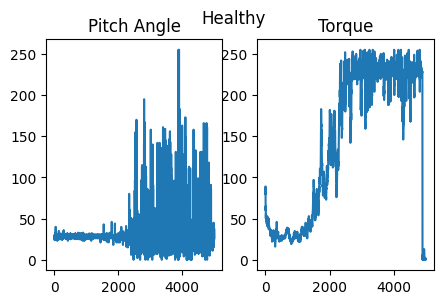

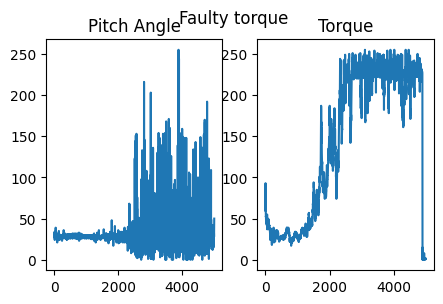

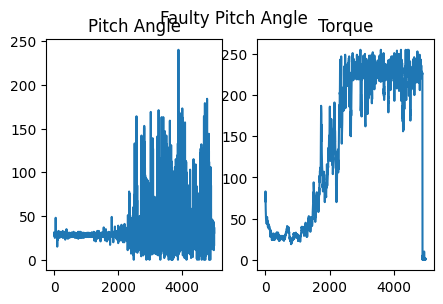

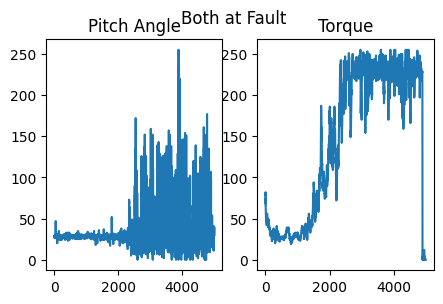

In [4]:
# plot one observation from each operating mode
indices_0 = np.where(y==0)[0]
indices_1 = np.where(y==1)[0]
indices_2 = np.where(y==2)[0]
indices_3 = np.where(y==3)[0]

indices = []
indices.append(indices_0[0])
indices.append(indices_1[0])
indices.append(indices_2[0])
indices.append(indices_3[0])
titles = ["Healthy", "Faulty torque", "Faulty Pitch Angle", "Both at Fault"]
for i in range(4):
  plt.subplots(1, 2, figsize=(5,3))
  plt.subplot(1,2,1)
  plt.plot(time_series_1[indices[i]])   # pitch angle
  plt.title("Pitch Angle")
  plt.subplot(1,2,2)
  plt.plot(time_series_2[indices[i]])   # torque
  plt.title("Torque")
  plt.suptitle(titles[i])
plt.show()

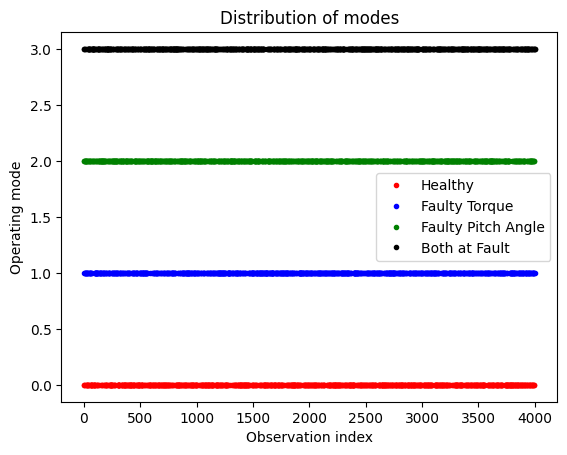

In [5]:
# Check distribution of different turbine states
plt.figure()
plt.plot(indices_0, np.ones(len(indices_0))*0, 'r.')
plt.plot(indices_1, np.ones(len(indices_1))*1, 'b.')
plt.plot(indices_2, np.ones(len(indices_2))*2, 'g.')
plt.plot(indices_3, np.ones(len(indices_3))*3, 'k.')
plt.legend(["Healthy", "Faulty Torque", "Faulty Pitch Angle", "Both at Fault"])
plt.xlabel("Observation index")
plt.ylabel("Operating mode")
plt.title("Distribution of modes")
plt.show()

# The plot below shows that each operating mode is equally distributed in the dataset

## Q1
### Choice of the sequence prediction approach:
The output prediction is the operating mode of the turbine. This is a scalar of fixed length. During prediction, when the time series is analyzed by the network, we do not need the outputs at the intermediate time points. Therefore, a sequence-to-vector prediction approach best suits this problem. 

### Shape of the data:
The prediction problem is specified as follows.
- Sequences of 5000 sensor readings are used to predict the operating state of the turbine.
- The two sensor readings are combined so that each reading has 2 features (pitch angle and torque).

Therefore the input will be of shape (batch_size x 5000 x 2) and the output will be of shape (batch_size)

## Q2
### Iterator for the Dataset
The function `tf.data.Dataset.from_tensor_slices` is used to create the iterator for the dataset. This is done by  
- expanding the dimensions of each timeseries from (4000, 5000) to (4000, 5000, 1),
- concatenating the two timeseries along the last dimension to get the dataset of shape (4000, 5000, 2),
- splitting the dataset into (60, 20, 20) ratio.

In [6]:
# Create a train, validation, test split of 60, 20, 20

# Combine the two sensor readings
ts1 = np.expand_dims(time_series_1, axis=2)
ts2 = np.expand_dims(time_series_2, axis=2)

print("Shape of the time series 1 after expanding: {}".format(ts1.shape))
print("Shape of the time series 2 after expanding: {}".format(ts2.shape))

# Concatenate along the last dimension
X = np.concatenate((ts1, ts2), axis=2)
print("Shape of the concatenated dataset: {}".format(X.shape))

# Split the dataset
# We see from the plot before that samples with different outcomes are distributed
# equally across the 4000 samples. Therefore we take that first 60% as training,
# 20% as validation and the rest 20% as test samples

training_length = int(0.6 * X.shape[0])
validation_length = int(0.2 * X.shape[0])

# Standardize the data using the mean and std of the training data
mean = X[:training_length].mean(axis=0)
std = X[:training_length].std(axis=0)
X = (X - mean) / std

# Split
batch_size = 32
shuffle_buffer = 4000

X_train_dataset = X[0:training_length,:]
Y_train = y[0:training_length]

X_val_dataset = X[training_length:training_length + validation_length,:]
Y_val = y[training_length:training_length + validation_length]

X_test_dataset = X[training_length + validation_length:,:]
Y_test = y[training_length + validation_length:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_dataset, Y_train)).shuffle(shuffle_buffer).batch(batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (X_val_dataset, Y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_dataset, Y_test)).batch(batch_size)

Shape of the time series 1 after expanding: (4000, 5000, 1)
Shape of the time series 2 after expanding: (4000, 5000, 1)
Shape of the concatenated dataset: (4000, 5000, 2)


In [7]:
# Check number of samples in each of the datasets
def dataset_size(dataset):
  count = 0
  for item in dataset:
    count += batch_size
  return count

print("Training set count: {}".format(dataset_size(train_dataset)))
print("Validation set count: {}".format(dataset_size(validation_dataset)))
print("Test set count: {}".format(dataset_size(test_dataset)))

# Check batch size
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

Training set count: 2400
Validation set count: 800
Test set count: 800
samples shape: (32, 5000, 2)
targets shape: (32,)


### Establish baselines

The simplest baseline is randomly assigning an operating mode to the samples. In this case the mean accuracy will be about 0.25.

Another approach to establish a baseline without using any neural network can be multinomial logistic regression, without considering the time aspect of the data. Accuracy of the validation datset here is 0.86

In [8]:
# Reshape dataset for baselines
X_train_lr=X_train_dataset.reshape(X_train_dataset.shape[0], X_train_dataset.shape[1]*X_train_dataset.shape[2])
X_val_lr=X_val_dataset.reshape(X_val_dataset.shape[0], X_val_dataset.shape[1]*X_val_dataset.shape[2])
X_test_lr=X_test_dataset.reshape(X_test_dataset.shape[0], X_test_dataset.shape[1]*X_test_dataset.shape[2])

In [14]:
####################
# RANDOM BASELINE 
####################
# Random predictions
num_samples = X_val_lr.shape[0]
mean_accuracy = 0
num_trials = 10000
for i in range(num_trials):
  random_predictions = np.random.choice([0, 1, 2, 3], size=num_samples)
  mean_accuracy += np.mean(random_predictions == Y_val)
mean_accuracy /= num_trials
print("Accuracy of Random baseline: {}".format(mean_accuracy))

###################################
# Multinomial Logistic Regression 
###################################
# Multinomial regression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X_train_lr, Y_train)

# Prediction on validation data
Y_pred = clf.predict(X_val_lr)

# Accuracy of the predictions
accuracy = accuracy_score(Y_val, Y_pred)
print("Accuracy of Random baseline: {}".format(accuracy))

Accuracy of Random baseline: 0.24988262499999925
Accuracy of Random baseline: 0.86625


## Q3

Trying out neural network with different types of layers to predict the operating mode of the wind turbine based on the sensor data.

### A simple dense network
This network consists of two dense layers with 32 and 4 neurons respectively. The activation for the first layer is ReLU and for the final layer is SoftMax.

The accuracy for this network on the validation dataset is 0.862.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 320,164
Trainable params: 320,164
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
75/75 [==============================] - 3s 25ms/step - loss: 0.5425 - accuracy: 0.8421 - val_loss: 0.5333 - val_accuracy: 0.8125
Epoch 2/100
75/75 [==============================] - 2s 23ms/step - loss: 0.1156 - accuracy: 0.9588 - val_loss: 0.4977 - val_accuracy: 0.8537
Epoch 3/100
75/75 [===========

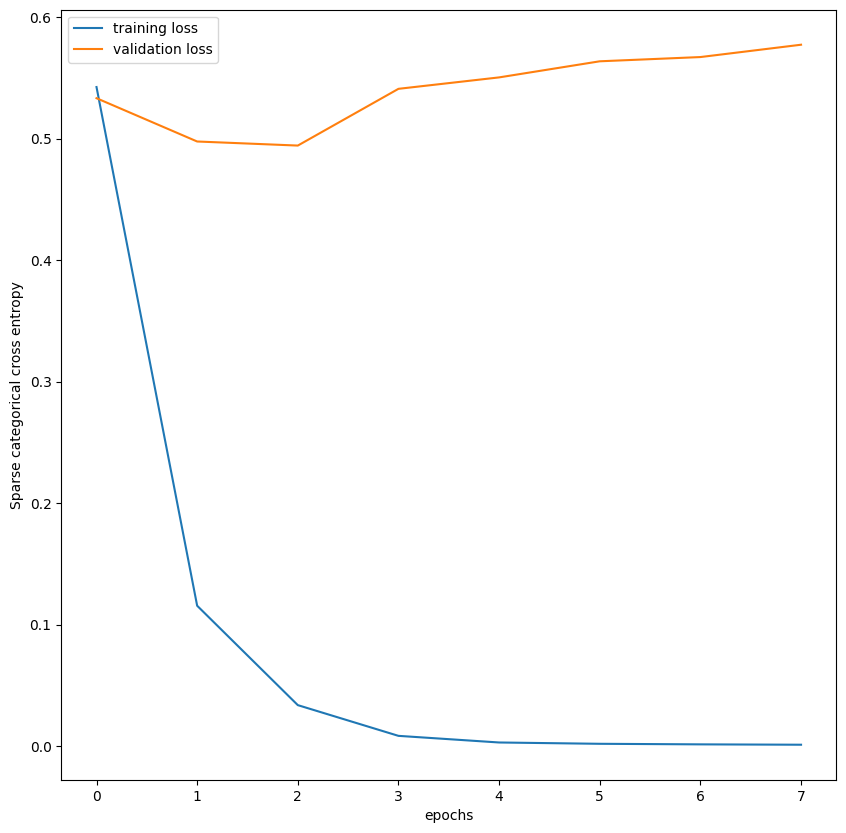

In [13]:
# A simple Dense Network
tf.keras.backend.clear_session()
tf.random.set_seed(678)
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1], X.shape[2])),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(4, activation = "softmax")])
model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbine_mode",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint_cb, early_cb])

model = tf.keras.models.load_model("turbine_mode")
print(f"Validation Accuracy Dense: {model.evaluate(validation_dataset)[1]:.4f}")


# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

### Network with Conv1D layers
This network consists of Conv1D layers and MaxPooling. The accuracy on the validation dataset for this network is 0.70

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4977, 8)           392       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2488, 8)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2477, 8)           776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1238, 8)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1233, 8)           392       
                                                                 
 global_average_pooling1d (G  (None, 8)                0

75/75 [==============================] - 8s 23ms/step - loss: 1.3875 - accuracy: 0.2533 - val_loss: 1.3867 - val_accuracy: 0.2262
Epoch 2/200
75/75 [==============================] - 1s 10ms/step - loss: 1.3863 - accuracy: 0.2550 - val_loss: 1.3870 - val_accuracy: 0.2262
Epoch 3/200
74/75 [============================>.] - ETA: 0s - loss: 1.3861 - accuracy: 0.2584

75/75 [==============================] - 1s 19ms/step - loss: 1.3861 - accuracy: 0.2571 - val_loss: 1.3864 - val_accuracy: 0.2262
Epoch 4/200
75/75 [==============================] - ETA: 0s - loss: 1.3690 - accuracy: 0.2650

75/75 [==============================] - 3s 34ms/step - loss: 1.3690 - accuracy: 0.2650 - val_loss: 1.3391 - val_accuracy: 0.2975
Epoch 5/200
68/75 [==========================>...] - ETA: 0s - loss: 1.2929 - accuracy: 0.3856

75/75 [==============================] - 1s 20ms/step - loss: 1.2841 - accuracy: 0.3917 - val_loss: 1.2614 - val_accuracy: 0.4450
Epoch 6/200
75/75 [==============================] - 1s 8ms/step - loss: 1.2582 - accuracy: 0.4196 - val_loss: 1.2795 - val_accuracy: 0.3800
Epoch 7/200
75/75 [==============================] - 1s 8ms/step - loss: 1.2484 - accuracy: 0.4200 - val_loss: 1.2616 - val_accuracy: 0.4187
Epoch 8/200
68/75 [==========================>...] - ETA: 0s - loss: 1.2413 - accuracy: 0.4177

75/75 [==============================] - 2s 26ms/step - loss: 1.2390 - accuracy: 0.4225 - val_loss: 1.2472 - val_accuracy: 0.4450
Epoch 9/200
75/75 [==============================] - 1s 8ms/step - loss: 1.2345 - accuracy: 0.4421 - val_loss: 1.2477 - val_accuracy: 0.4275
Epoch 10/200
66/75 [=========================>....] - ETA: 0s - loss: 1.2300 - accuracy: 0.4337

75/75 [==============================] - 2s 22ms/step - loss: 1.2293 - accuracy: 0.4408 - val_loss: 1.2464 - val_accuracy: 0.4475
Epoch 11/200
75/75 [==============================] - 1s 7ms/step - loss: 1.2268 - accuracy: 0.4367 - val_loss: 1.2578 - val_accuracy: 0.4137
Epoch 12/200
69/75 [==========================>...] - ETA: 0s - loss: 1.2263 - accuracy: 0.4380

75/75 [==============================] - 1s 18ms/step - loss: 1.2283 - accuracy: 0.4375 - val_loss: 1.2418 - val_accuracy: 0.4387
Epoch 13/200
75/75 [==============================] - 1s 7ms/step - loss: 1.2230 - accuracy: 0.4658 - val_loss: 1.2700 - val_accuracy: 0.4075
Epoch 14/200
75/75 [==============================] - 0s 7ms/step - loss: 1.2220 - accuracy: 0.4437 - val_loss: 1.2433 - val_accuracy: 0.4412
Epoch 15/200
70/75 [===========================>..] - ETA: 0s - loss: 1.2236 - accuracy: 0.4232

75/75 [==============================] - 1s 18ms/step - loss: 1.2216 - accuracy: 0.4254 - val_loss: 1.2401 - val_accuracy: 0.4300
Epoch 16/200
74/75 [============================>.] - ETA: 0s - loss: 1.2214 - accuracy: 0.4421

75/75 [==============================] - 2s 26ms/step - loss: 1.2202 - accuracy: 0.4429 - val_loss: 1.2345 - val_accuracy: 0.4150
Epoch 17/200
75/75 [==============================] - 1s 9ms/step - loss: 1.2170 - accuracy: 0.4475 - val_loss: 1.2485 - val_accuracy: 0.4400
Epoch 18/200
67/75 [=========================>....] - ETA: 0s - loss: 1.2141 - accuracy: 0.4496

75/75 [==============================] - 1s 19ms/step - loss: 1.2139 - accuracy: 0.4525 - val_loss: 1.2343 - val_accuracy: 0.4512
Epoch 19/200
75/75 [==============================] - 1s 9ms/step - loss: 1.2122 - accuracy: 0.4508 - val_loss: 1.2382 - val_accuracy: 0.3950
Epoch 20/200
68/75 [==========================>...] - ETA: 0s - loss: 1.2136 - accuracy: 0.4531

75/75 [==============================] - 1s 19ms/step - loss: 1.2116 - accuracy: 0.4504 - val_loss: 1.2325 - val_accuracy: 0.4350
Epoch 21/200
75/75 [==============================] - 0s 6ms/step - loss: 1.2069 - accuracy: 0.4550 - val_loss: 1.2372 - val_accuracy: 0.4300
Epoch 22/200
75/75 [==============================] - 0s 7ms/step - loss: 1.2077 - accuracy: 0.4596 - val_loss: 1.2472 - val_accuracy: 0.4150
Epoch 23/200
71/75 [===========================>..] - ETA: 0s - loss: 1.2099 - accuracy: 0.4533

75/75 [==============================] - 1s 18ms/step - loss: 1.2123 - accuracy: 0.4479 - val_loss: 1.2279 - val_accuracy: 0.4450
Epoch 24/200
75/75 [==============================] - 1s 7ms/step - loss: 1.2028 - accuracy: 0.4437 - val_loss: 1.2329 - val_accuracy: 0.4412
Epoch 25/200
69/75 [==========================>...] - ETA: 0s - loss: 1.1967 - accuracy: 0.4543

75/75 [==============================] - 2s 24ms/step - loss: 1.1980 - accuracy: 0.4512 - val_loss: 1.2206 - val_accuracy: 0.4487
Epoch 26/200
70/75 [===========================>..] - ETA: 0s - loss: 1.1959 - accuracy: 0.4661

75/75 [==============================] - 2s 22ms/step - loss: 1.1972 - accuracy: 0.4663 - val_loss: 1.2188 - val_accuracy: 0.4350
Epoch 27/200
74/75 [============================>.] - ETA: 0s - loss: 1.1887 - accuracy: 0.4721

75/75 [==============================] - 1s 19ms/step - loss: 1.1897 - accuracy: 0.4712 - val_loss: 1.2052 - val_accuracy: 0.4525
Epoch 28/200
75/75 [==============================] - 1s 7ms/step - loss: 1.1812 - accuracy: 0.4825 - val_loss: 1.2442 - val_accuracy: 0.4325
Epoch 29/200
68/75 [==========================>...] - ETA: 0s - loss: 1.1725 - accuracy: 0.4816

75/75 [==============================] - 1s 18ms/step - loss: 1.1695 - accuracy: 0.4867 - val_loss: 1.1776 - val_accuracy: 0.4875
Epoch 30/200
68/75 [==========================>...] - ETA: 0s - loss: 1.1517 - accuracy: 0.5064

75/75 [==============================] - 2s 20ms/step - loss: 1.1513 - accuracy: 0.5071 - val_loss: 1.1619 - val_accuracy: 0.5138
Epoch 31/200
72/75 [===========================>..] - ETA: 0s - loss: 1.1281 - accuracy: 0.5451

75/75 [==============================] - 1s 19ms/step - loss: 1.1291 - accuracy: 0.5442 - val_loss: 1.1497 - val_accuracy: 0.5200
Epoch 32/200
73/75 [============================>.] - ETA: 0s - loss: 1.1181 - accuracy: 0.5415

75/75 [==============================] - 2s 22ms/step - loss: 1.1207 - accuracy: 0.5404 - val_loss: 1.1348 - val_accuracy: 0.5462
Epoch 33/200
70/75 [===========================>..] - ETA: 0s - loss: 1.1003 - accuracy: 0.5549

75/75 [==============================] - 2s 22ms/step - loss: 1.0986 - accuracy: 0.5529 - val_loss: 1.1280 - val_accuracy: 0.5325
Epoch 34/200
75/75 [==============================] - 1s 8ms/step - loss: 1.0888 - accuracy: 0.5575 - val_loss: 1.1417 - val_accuracy: 0.5150
Epoch 35/200
75/75 [==============================] - 1s 7ms/step - loss: 1.0740 - accuracy: 0.5667 - val_loss: 1.1780 - val_accuracy: 0.4875
Epoch 36/200
69/75 [==========================>...] - ETA: 0s - loss: 1.0394 - accuracy: 0.6046

75/75 [==============================] - 1s 18ms/step - loss: 1.0461 - accuracy: 0.5962 - val_loss: 1.0913 - val_accuracy: 0.5288
Epoch 37/200
75/75 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.5908

75/75 [==============================] - 2s 21ms/step - loss: 1.0384 - accuracy: 0.5908 - val_loss: 1.0802 - val_accuracy: 0.5500
Epoch 38/200
73/75 [============================>.] - ETA: 0s - loss: 1.0226 - accuracy: 0.5972

75/75 [==============================] - 1s 19ms/step - loss: 1.0205 - accuracy: 0.5992 - val_loss: 1.0530 - val_accuracy: 0.5763
Epoch 39/200
75/75 [==============================] - 1s 9ms/step - loss: 1.0125 - accuracy: 0.5954 - val_loss: 1.0587 - val_accuracy: 0.5500
Epoch 40/200
74/75 [============================>.] - ETA: 0s - loss: 0.9996 - accuracy: 0.5908

75/75 [==============================] - 2s 28ms/step - loss: 1.0008 - accuracy: 0.5908 - val_loss: 1.0193 - val_accuracy: 0.5925
Epoch 41/200
75/75 [==============================] - 1s 8ms/step - loss: 0.9852 - accuracy: 0.6054 - val_loss: 1.0471 - val_accuracy: 0.5412
Epoch 42/200
67/75 [=========================>....] - ETA: 0s - loss: 0.9750 - accuracy: 0.6040

75/75 [==============================] - 2s 22ms/step - loss: 0.9762 - accuracy: 0.6058 - val_loss: 1.0052 - val_accuracy: 0.5713
Epoch 43/200
75/75 [==============================] - 0s 6ms/step - loss: 0.9666 - accuracy: 0.6025 - val_loss: 1.0085 - val_accuracy: 0.5525
Epoch 44/200
70/75 [===========================>..] - ETA: 0s - loss: 0.9500 - accuracy: 0.6085

75/75 [==============================] - 1s 18ms/step - loss: 0.9496 - accuracy: 0.6054 - val_loss: 1.0038 - val_accuracy: 0.5450
Epoch 45/200
68/75 [==========================>...] - ETA: 0s - loss: 0.9347 - accuracy: 0.6089

75/75 [==============================] - 2s 20ms/step - loss: 0.9398 - accuracy: 0.6054 - val_loss: 0.9708 - val_accuracy: 0.5800
Epoch 46/200
69/75 [==========================>...] - ETA: 0s - loss: 0.9397 - accuracy: 0.5992

75/75 [==============================] - 1s 19ms/step - loss: 0.9354 - accuracy: 0.6037 - val_loss: 0.9662 - val_accuracy: 0.5938
Epoch 47/200
68/75 [==========================>...] - ETA: 0s - loss: 0.9238 - accuracy: 0.6094

75/75 [==============================] - 1s 18ms/step - loss: 0.9193 - accuracy: 0.6112 - val_loss: 0.9564 - val_accuracy: 0.5925
Epoch 48/200
75/75 [==============================] - 1s 7ms/step - loss: 0.9226 - accuracy: 0.6171 - val_loss: 0.9713 - val_accuracy: 0.5412
Epoch 49/200
75/75 [==============================] - 1s 9ms/step - loss: 0.9129 - accuracy: 0.6137 - val_loss: 0.9732 - val_accuracy: 0.5387
Epoch 50/200
70/75 [===========================>..] - ETA: 0s - loss: 0.8895 - accuracy: 0.6179

75/75 [==============================] - 2s 23ms/step - loss: 0.8901 - accuracy: 0.6192 - val_loss: 0.9305 - val_accuracy: 0.5900
Epoch 51/200
75/75 [==============================] - 1s 8ms/step - loss: 0.8826 - accuracy: 0.6187 - val_loss: 0.9502 - val_accuracy: 0.5738
Epoch 52/200
75/75 [==============================] - 1s 7ms/step - loss: 0.8815 - accuracy: 0.6258 - val_loss: 0.9832 - val_accuracy: 0.5500
Epoch 53/200
75/75 [==============================] - 1s 7ms/step - loss: 0.8790 - accuracy: 0.6171 - val_loss: 0.9357 - val_accuracy: 0.5475
Epoch 54/200
69/75 [==========================>...] - ETA: 0s - loss: 0.8682 - accuracy: 0.6250

75/75 [==============================] - 2s 22ms/step - loss: 0.8692 - accuracy: 0.6246 - val_loss: 0.9200 - val_accuracy: 0.6037
Epoch 55/200
67/75 [=========================>....] - ETA: 0s - loss: 0.8656 - accuracy: 0.6297

75/75 [==============================] - 2s 20ms/step - loss: 0.8595 - accuracy: 0.6317 - val_loss: 0.9100 - val_accuracy: 0.5663
Epoch 56/200
72/75 [===========================>..] - ETA: 0s - loss: 0.8514 - accuracy: 0.6354

75/75 [==============================] - 1s 19ms/step - loss: 0.8516 - accuracy: 0.6350 - val_loss: 0.9064 - val_accuracy: 0.6012
Epoch 57/200
75/75 [==============================] - 1s 8ms/step - loss: 0.8303 - accuracy: 0.6442 - val_loss: 0.9116 - val_accuracy: 0.6075
Epoch 58/200
66/75 [=========================>....] - ETA: 0s - loss: 0.8347 - accuracy: 0.6245

75/75 [==============================] - 2s 24ms/step - loss: 0.8286 - accuracy: 0.6275 - val_loss: 0.8902 - val_accuracy: 0.6150
Epoch 59/200
75/75 [==============================] - 1s 10ms/step - loss: 0.8210 - accuracy: 0.6454 - val_loss: 0.9125 - val_accuracy: 0.6075
Epoch 60/200
70/75 [===========================>..] - ETA: 0s - loss: 0.8106 - accuracy: 0.6500

75/75 [==============================] - 2s 25ms/step - loss: 0.8138 - accuracy: 0.6517 - val_loss: 0.8736 - val_accuracy: 0.5950
Epoch 61/200
75/75 [==============================] - 1s 7ms/step - loss: 0.8057 - accuracy: 0.6500 - val_loss: 0.8828 - val_accuracy: 0.6162
Epoch 62/200
75/75 [==============================] - 1s 7ms/step - loss: 0.7968 - accuracy: 0.6567 - val_loss: 0.9003 - val_accuracy: 0.6087
Epoch 63/200
69/75 [==========================>...] - ETA: 0s - loss: 0.8053 - accuracy: 0.6495

75/75 [==============================] - 1s 18ms/step - loss: 0.8005 - accuracy: 0.6550 - val_loss: 0.8485 - val_accuracy: 0.6350
Epoch 64/200
75/75 [==============================] - 0s 7ms/step - loss: 0.7805 - accuracy: 0.6600 - val_loss: 0.8600 - val_accuracy: 0.6075
Epoch 65/200
69/75 [==========================>...] - ETA: 0s - loss: 0.8043 - accuracy: 0.6540

75/75 [==============================] - 1s 18ms/step - loss: 0.8007 - accuracy: 0.6571 - val_loss: 0.8418 - val_accuracy: 0.6200
Epoch 66/200
71/75 [===========================>..] - ETA: 0s - loss: 0.7774 - accuracy: 0.6646

75/75 [==============================] - 2s 22ms/step - loss: 0.7824 - accuracy: 0.6642 - val_loss: 0.8298 - val_accuracy: 0.6300
Epoch 67/200
75/75 [==============================] - 1s 9ms/step - loss: 0.7616 - accuracy: 0.6737 - val_loss: 0.8404 - val_accuracy: 0.6175
Epoch 68/200
75/75 [==============================] - 1s 9ms/step - loss: 0.7679 - accuracy: 0.6696 - val_loss: 0.8320 - val_accuracy: 0.6237
Epoch 69/200
70/75 [===========================>..] - ETA: 0s - loss: 0.7517 - accuracy: 0.6795

75/75 [==============================] - 2s 21ms/step - loss: 0.7541 - accuracy: 0.6762 - val_loss: 0.8219 - val_accuracy: 0.6375
Epoch 70/200
75/75 [==============================] - 1s 8ms/step - loss: 0.7587 - accuracy: 0.6717 - val_loss: 0.9029 - val_accuracy: 0.5612
Epoch 71/200
75/75 [==============================] - 1s 7ms/step - loss: 0.7548 - accuracy: 0.6729 - val_loss: 0.8257 - val_accuracy: 0.6012
Epoch 72/200
75/75 [==============================] - 0s 6ms/step - loss: 0.7385 - accuracy: 0.6858 - val_loss: 0.8400 - val_accuracy: 0.6375
Epoch 73/200
75/75 [==============================] - 0s 6ms/step - loss: 0.7372 - accuracy: 0.6933 - val_loss: 0.8345 - val_accuracy: 0.5975
Epoch 74/200
75/75 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.6787

75/75 [==============================] - 1s 19ms/step - loss: 0.7478 - accuracy: 0.6787 - val_loss: 0.8183 - val_accuracy: 0.6050
Epoch 75/200
75/75 [==============================] - 0s 6ms/step - loss: 0.7249 - accuracy: 0.6892 - val_loss: 0.8373 - val_accuracy: 0.6025
Epoch 76/200
75/75 [==============================] - 0s 7ms/step - loss: 0.7258 - accuracy: 0.6871 - val_loss: 0.8189 - val_accuracy: 0.6112
Epoch 77/200
75/75 [==============================] - 1s 7ms/step - loss: 0.7260 - accuracy: 0.6867 - val_loss: 0.8345 - val_accuracy: 0.6662
Epoch 78/200
71/75 [===========================>..] - ETA: 0s - loss: 0.7101 - accuracy: 0.6932

75/75 [==============================] - 1s 18ms/step - loss: 0.7085 - accuracy: 0.6942 - val_loss: 0.7988 - val_accuracy: 0.6500
Epoch 79/200
74/75 [============================>.] - ETA: 0s - loss: 0.7109 - accuracy: 0.6888

75/75 [==============================] - 2s 28ms/step - loss: 0.7096 - accuracy: 0.6896 - val_loss: 0.7764 - val_accuracy: 0.6562
Epoch 80/200
75/75 [==============================] - 1s 8ms/step - loss: 0.7054 - accuracy: 0.7017 - val_loss: 0.7793 - val_accuracy: 0.6325
Epoch 81/200
75/75 [==============================] - 1s 7ms/step - loss: 0.7021 - accuracy: 0.7025 - val_loss: 0.7898 - val_accuracy: 0.6300
Epoch 82/200
69/75 [==========================>...] - ETA: 0s - loss: 0.7285 - accuracy: 0.6789

75/75 [==============================] - 1s 18ms/step - loss: 0.7257 - accuracy: 0.6796 - val_loss: 0.7697 - val_accuracy: 0.6463
Epoch 83/200
75/75 [==============================] - 1s 8ms/step - loss: 0.6990 - accuracy: 0.7117 - val_loss: 0.7755 - val_accuracy: 0.6438
Epoch 84/200
66/75 [=========================>....] - ETA: 0s - loss: 0.7010 - accuracy: 0.6946

75/75 [==============================] - 2s 23ms/step - loss: 0.6895 - accuracy: 0.7046 - val_loss: 0.7538 - val_accuracy: 0.6825
Epoch 85/200
75/75 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.6942

75/75 [==============================] - 2s 21ms/step - loss: 0.6930 - accuracy: 0.6942 - val_loss: 0.7468 - val_accuracy: 0.6687
Epoch 86/200
75/75 [==============================] - 1s 10ms/step - loss: 0.6772 - accuracy: 0.7158 - val_loss: 0.7770 - val_accuracy: 0.6538
Epoch 87/200
72/75 [===========================>..] - ETA: 0s - loss: 0.6692 - accuracy: 0.7101

75/75 [==============================] - 2s 24ms/step - loss: 0.6684 - accuracy: 0.7133 - val_loss: 0.7422 - val_accuracy: 0.6950
Epoch 88/200
75/75 [==============================] - 1s 7ms/step - loss: 0.6614 - accuracy: 0.7150 - val_loss: 0.7751 - val_accuracy: 0.6575
Epoch 89/200
75/75 [==============================] - 0s 6ms/step - loss: 0.6695 - accuracy: 0.7113 - val_loss: 0.7917 - val_accuracy: 0.6100
Epoch 90/200
75/75 [==============================] - 0s 7ms/step - loss: 0.6713 - accuracy: 0.7104 - val_loss: 0.7809 - val_accuracy: 0.6137
Epoch 91/200
71/75 [===========================>..] - ETA: 0s - loss: 0.6625 - accuracy: 0.7192

75/75 [==============================] - 1s 18ms/step - loss: 0.6598 - accuracy: 0.7196 - val_loss: 0.7361 - val_accuracy: 0.6525
Epoch 92/200
74/75 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.7158

75/75 [==============================] - 1s 20ms/step - loss: 0.6525 - accuracy: 0.7154 - val_loss: 0.7198 - val_accuracy: 0.6700
Epoch 93/200
75/75 [==============================] - 1s 7ms/step - loss: 0.6594 - accuracy: 0.7188 - val_loss: 0.7436 - val_accuracy: 0.6438
Epoch 94/200
75/75 [==============================] - 1s 7ms/step - loss: 0.6476 - accuracy: 0.7196 - val_loss: 0.7257 - val_accuracy: 0.7013
Epoch 95/200
75/75 [==============================] - 0s 6ms/step - loss: 0.6341 - accuracy: 0.7271 - val_loss: 0.7266 - val_accuracy: 0.7125
Epoch 96/200
75/75 [==============================] - 0s 7ms/step - loss: 0.6420 - accuracy: 0.7333 - val_loss: 0.7469 - val_accuracy: 0.6438
Epoch 97/200
71/75 [===========================>..] - ETA: 0s - loss: 0.6608 - accuracy: 0.7091

75/75 [==============================] - 1s 18ms/step - loss: 0.6540 - accuracy: 0.7150 - val_loss: 0.7152 - val_accuracy: 0.6913
Epoch 98/200
75/75 [==============================] - 1s 9ms/step - loss: 0.6362 - accuracy: 0.7287 - val_loss: 0.7231 - val_accuracy: 0.6637
Epoch 99/200
75/75 [==============================] - 1s 9ms/step - loss: 0.6401 - accuracy: 0.7267 - val_loss: 0.7877 - val_accuracy: 0.6300
Epoch 100/200
75/75 [==============================] - 1s 8ms/step - loss: 0.6308 - accuracy: 0.7246 - val_loss: 0.8327 - val_accuracy: 0.6625
Epoch 101/200
67/75 [=========================>....] - ETA: 0s - loss: 0.6261 - accuracy: 0.7337

75/75 [==============================] - 1s 18ms/step - loss: 0.6274 - accuracy: 0.7312 - val_loss: 0.6997 - val_accuracy: 0.6625
Epoch 102/200
75/75 [==============================] - 1s 7ms/step - loss: 0.6220 - accuracy: 0.7387 - val_loss: 0.7443 - val_accuracy: 0.6500
Epoch 103/200
75/75 [==============================] - 1s 7ms/step - loss: 0.6117 - accuracy: 0.7475 - val_loss: 0.7011 - val_accuracy: 0.6875
Epoch 104/200
68/75 [==========================>...] - ETA: 0s - loss: 0.6058 - accuracy: 0.7426

75/75 [==============================] - 2s 23ms/step - loss: 0.6102 - accuracy: 0.7412 - val_loss: 0.6916 - val_accuracy: 0.6975
Epoch 105/200
75/75 [==============================] - 1s 7ms/step - loss: 0.6405 - accuracy: 0.7237 - val_loss: 0.6929 - val_accuracy: 0.7200
Epoch 106/200
75/75 [==============================] - 1s 7ms/step - loss: 0.6075 - accuracy: 0.7492 - val_loss: 0.6979 - val_accuracy: 0.6950
Epoch 107/200
71/75 [===========================>..] - ETA: 0s - loss: 0.6050 - accuracy: 0.7491

75/75 [==============================] - 1s 18ms/step - loss: 0.6070 - accuracy: 0.7458 - val_loss: 0.6769 - val_accuracy: 0.7113
Epoch 108/200
75/75 [==============================] - 1s 7ms/step - loss: 0.6046 - accuracy: 0.7421 - val_loss: 0.6873 - val_accuracy: 0.7163
Epoch 109/200
70/75 [===========================>..] - ETA: 0s - loss: 0.5990 - accuracy: 0.7478

75/75 [==============================] - 1s 19ms/step - loss: 0.5955 - accuracy: 0.7521 - val_loss: 0.6769 - val_accuracy: 0.6975
Epoch 110/200
67/75 [=========================>....] - ETA: 0s - loss: 0.5933 - accuracy: 0.7523

75/75 [==============================] - 2s 21ms/step - loss: 0.5890 - accuracy: 0.7579 - val_loss: 0.6735 - val_accuracy: 0.7262
Epoch 111/200
75/75 [==============================] - 1s 10ms/step - loss: 0.6010 - accuracy: 0.7396 - val_loss: 0.6907 - val_accuracy: 0.7175
Epoch 112/200
75/75 [==============================] - 1s 10ms/step - loss: 0.5900 - accuracy: 0.7604 - val_loss: 0.6747 - val_accuracy: 0.6850
Epoch 113/200
75/75 [==============================] - 1s 8ms/step - loss: 0.5825 - accuracy: 0.7638 - val_loss: 0.6781 - val_accuracy: 0.7425
Epoch 114/200
75/75 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.7642

75/75 [==============================] - 1s 19ms/step - loss: 0.5847 - accuracy: 0.7642 - val_loss: 0.6727 - val_accuracy: 0.7000
Epoch 115/200
75/75 [==============================] - 1s 8ms/step - loss: 0.5787 - accuracy: 0.7650 - val_loss: 0.6760 - val_accuracy: 0.7025
Epoch 116/200
66/75 [=========================>....] - ETA: 0s - loss: 0.5684 - accuracy: 0.7732

75/75 [==============================] - 1s 19ms/step - loss: 0.5688 - accuracy: 0.7700 - val_loss: 0.6582 - val_accuracy: 0.7063
Epoch 117/200
75/75 [==============================] - 0s 7ms/step - loss: 0.5857 - accuracy: 0.7592 - val_loss: 0.6618 - val_accuracy: 0.6900
Epoch 118/200
75/75 [==============================] - 1s 7ms/step - loss: 0.5720 - accuracy: 0.7650 - val_loss: 0.6713 - val_accuracy: 0.7013
Epoch 119/200
75/75 [==============================] - 1s 7ms/step - loss: 0.5793 - accuracy: 0.7592 - val_loss: 0.6701 - val_accuracy: 0.6675
Epoch 120/200
67/75 [=========================>....] - ETA: 0s - loss: 0.5668 - accuracy: 0.7729

75/75 [==============================] - 2s 22ms/step - loss: 0.5702 - accuracy: 0.7696 - val_loss: 0.6463 - val_accuracy: 0.7050
Epoch 121/200
75/75 [==============================] - 1s 8ms/step - loss: 0.5704 - accuracy: 0.7579 - val_loss: 0.6862 - val_accuracy: 0.6725
Epoch 122/200
75/75 [==============================] - 1s 8ms/step - loss: 0.5624 - accuracy: 0.7713 - val_loss: 0.6825 - val_accuracy: 0.7212
Epoch 123/200
75/75 [==============================] - 1s 9ms/step - loss: 0.5568 - accuracy: 0.7696 - val_loss: 0.6804 - val_accuracy: 0.7038
Epoch 124/200
75/75 [==============================] - 1s 9ms/step - loss: 0.5883 - accuracy: 0.7504 - val_loss: 0.6990 - val_accuracy: 0.6925
Epoch 125/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.7050
Validation Accuracy Conv1D: 0.70


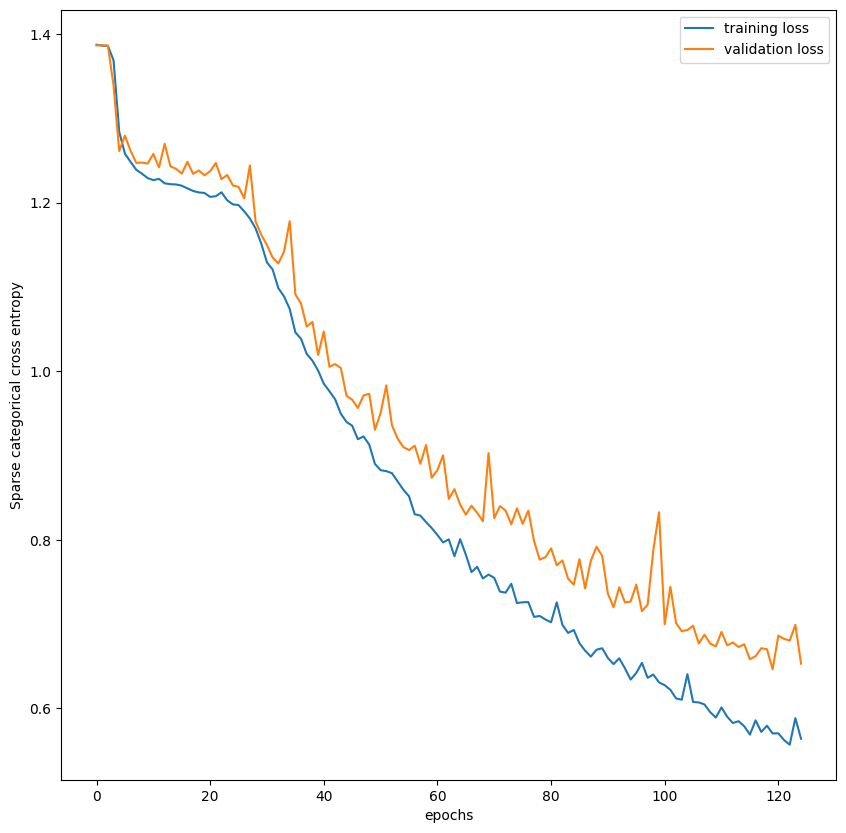

In [15]:
# A 1D Conv network

tf.keras.backend.clear_session()
tf.random.set_seed(1234)
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1], X.shape[2])),
    Conv1D(8, 24, activation="relu"),
    MaxPooling1D(2),
    Conv1D(8, 12, activation="relu"),
    MaxPooling1D(2),
    Conv1D(8, 6, activation="relu"),
    GlobalAveragePooling1D(),
    Dense(4, activation = "softmax")
    ])
model.summary()


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_conv1d",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])
history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint_cb, early_cb])

model = tf.keras.models.load_model("turbinemode_conv1d")
print(f"Validation Accuracy Conv1D: {model.evaluate(validation_dataset)[1]:.2f}")


# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

### Network with SimpleRNN layers
This is a recurrent neural network with SimpleRNN layers.   
This network takes a lot of time to train. Each epoch takes more than 880 seconds to run. Therefore, for improving training time and computational efficiency, GRU layers are used in the next network.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5000, 16)          304       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 900
Trainable params: 900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
75/75 [==============================] - 920s 12s/step - loss: 1.5931 - accuracy: 0.2629 - val_loss: 1.3576 - val_accuracy: 0.3150
Epoch 2/5
75/75 [==============================] 

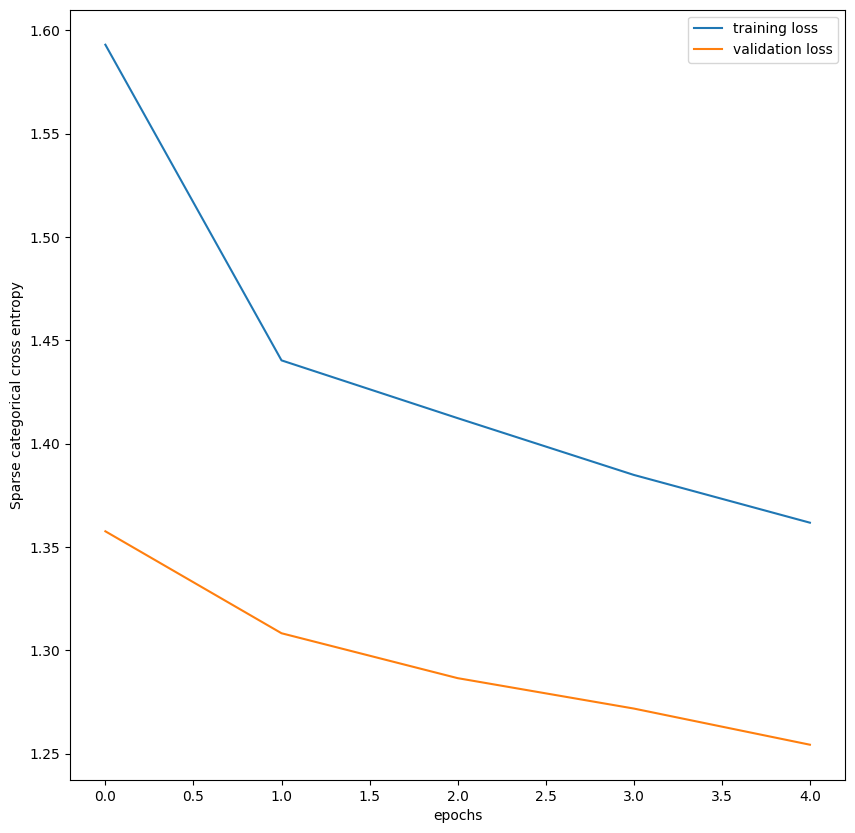

In [9]:
# A simple RNN network
tf.keras.backend.clear_session()
tf.random.set_seed(477)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1], X.shape[2])),
    SimpleRNN(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.25),
    SimpleRNN(16),
    Dropout(0.3),
    Dense(4, activation = "softmax")])
model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_rnn",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint_cb, early_cb])

model = tf.keras.models.load_model("turbinemode_rnn")
print(f"Validation Accuracy RNN: {model.evaluate(validation_dataset)[1]:.2f}")

# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

### Network with GRU layers
This is a recurrent neural network with GRU layers.   
The accuracy on the validation dataset for this network is 0.69.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5000, 32)          3456      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 9,924
Trainable params: 9,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 1.3638 - accuracy: 0.3225

75/75 [==============================] - 29s 321ms/step - loss: 1.3638 - accuracy: 0.3225 - val_loss: 1.3406 - val_accuracy: 0.3512
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 1.3229 - accuracy: 0.3862

75/75 [==============================] - 23s 302ms/step - loss: 1.3229 - accuracy: 0.3862 - val_loss: 1.3148 - val_accuracy: 0.3887
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 1.2662 - accuracy: 0.4329

75/75 [==============================] - 23s 305ms/step - loss: 1.2662 - accuracy: 0.4329 - val_loss: 1.2785 - val_accuracy: 0.4250
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 1.1946 - accuracy: 0.4737

75/75 [==============================] - 24s 314ms/step - loss: 1.1946 - accuracy: 0.4737 - val_loss: 1.1940 - val_accuracy: 0.4613
Epoch 5/100
75/75 [==============================] - ETA: 0s - loss: 1.1089 - accuracy: 0.4963

75/75 [==============================] - 24s 319ms/step - loss: 1.1089 - accuracy: 0.4963 - val_loss: 1.1196 - val_accuracy: 0.5088
Epoch 6/100
75/75 [==============================] - ETA: 0s - loss: 1.0464 - accuracy: 0.5487

75/75 [==============================] - 23s 302ms/step - loss: 1.0464 - accuracy: 0.5487 - val_loss: 1.0796 - val_accuracy: 0.5288
Epoch 7/100
75/75 [==============================] - ETA: 0s - loss: 0.9930 - accuracy: 0.5725

75/75 [==============================] - 23s 310ms/step - loss: 0.9930 - accuracy: 0.5725 - val_loss: 1.0418 - val_accuracy: 0.5475
Epoch 8/100
75/75 [==============================] - ETA: 0s - loss: 0.9480 - accuracy: 0.6058

75/75 [==============================] - 23s 311ms/step - loss: 0.9480 - accuracy: 0.6058 - val_loss: 1.0030 - val_accuracy: 0.5600
Epoch 9/100
75/75 [==============================] - ETA: 0s - loss: 0.9109 - accuracy: 0.6267

75/75 [==============================] - 23s 307ms/step - loss: 0.9109 - accuracy: 0.6267 - val_loss: 0.9639 - val_accuracy: 0.5863
Epoch 10/100
75/75 [==============================] - ETA: 0s - loss: 0.8737 - accuracy: 0.6383

75/75 [==============================] - 24s 314ms/step - loss: 0.8737 - accuracy: 0.6383 - val_loss: 0.9453 - val_accuracy: 0.5900
Epoch 11/100
75/75 [==============================] - ETA: 0s - loss: 0.8301 - accuracy: 0.6587

75/75 [==============================] - 24s 323ms/step - loss: 0.8301 - accuracy: 0.6587 - val_loss: 0.9393 - val_accuracy: 0.5863
Epoch 12/100
75/75 [==============================] - ETA: 0s - loss: 0.7901 - accuracy: 0.6796

75/75 [==============================] - 23s 310ms/step - loss: 0.7901 - accuracy: 0.6796 - val_loss: 0.9095 - val_accuracy: 0.6012
Epoch 13/100
75/75 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.6983

75/75 [==============================] - 23s 308ms/step - loss: 0.7533 - accuracy: 0.6983 - val_loss: 0.8541 - val_accuracy: 0.6313
Epoch 14/100
75/75 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.7150

75/75 [==============================] - 23s 312ms/step - loss: 0.7152 - accuracy: 0.7150 - val_loss: 0.8439 - val_accuracy: 0.6325
Epoch 15/100
75/75 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.7246

75/75 [==============================] - 23s 309ms/step - loss: 0.6809 - accuracy: 0.7246 - val_loss: 0.8168 - val_accuracy: 0.6500
Epoch 16/100
75/75 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.7404

75/75 [==============================] - 25s 339ms/step - loss: 0.6552 - accuracy: 0.7404 - val_loss: 0.8148 - val_accuracy: 0.6612
Epoch 17/100
75/75 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.7462

75/75 [==============================] - 23s 308ms/step - loss: 0.6236 - accuracy: 0.7462 - val_loss: 0.8031 - val_accuracy: 0.6662
Epoch 18/100
75/75 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.7579

75/75 [==============================] - 23s 311ms/step - loss: 0.6074 - accuracy: 0.7579 - val_loss: 0.7928 - val_accuracy: 0.6787
Epoch 19/100
75/75 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.7650

75/75 [==============================] - 23s 312ms/step - loss: 0.5784 - accuracy: 0.7650 - val_loss: 0.7675 - val_accuracy: 0.6900
Epoch 20/100
75/75 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.7808

75/75 [==============================] - 23s 311ms/step - loss: 0.5565 - accuracy: 0.7808 - val_loss: 0.7572 - val_accuracy: 0.6888
Epoch 21/100
75/75 [==============================] - 16s 217ms/step - loss: 0.5356 - accuracy: 0.7829 - val_loss: 0.7654 - val_accuracy: 0.6812
Epoch 22/100
75/75 [==============================] - 17s 223ms/step - loss: 0.5242 - accuracy: 0.7867 - val_loss: 0.7857 - val_accuracy: 0.6862
Epoch 23/100
75/75 [==============================] - 17s 227ms/step - loss: 0.5023 - accuracy: 0.8017 - val_loss: 0.7596 - val_accuracy: 0.7088
Epoch 24/100
75/75 [==============================] - 17s 224ms/step - loss: 0.4897 - accuracy: 0.8029 - val_loss: 0.7670 - val_accuracy: 0.7013
Epoch 25/100
25/25 [==============================] - 3s 87ms/step - loss: 0.7572 - accuracy: 0.6888
Validation Accuracy RNN: 0.69


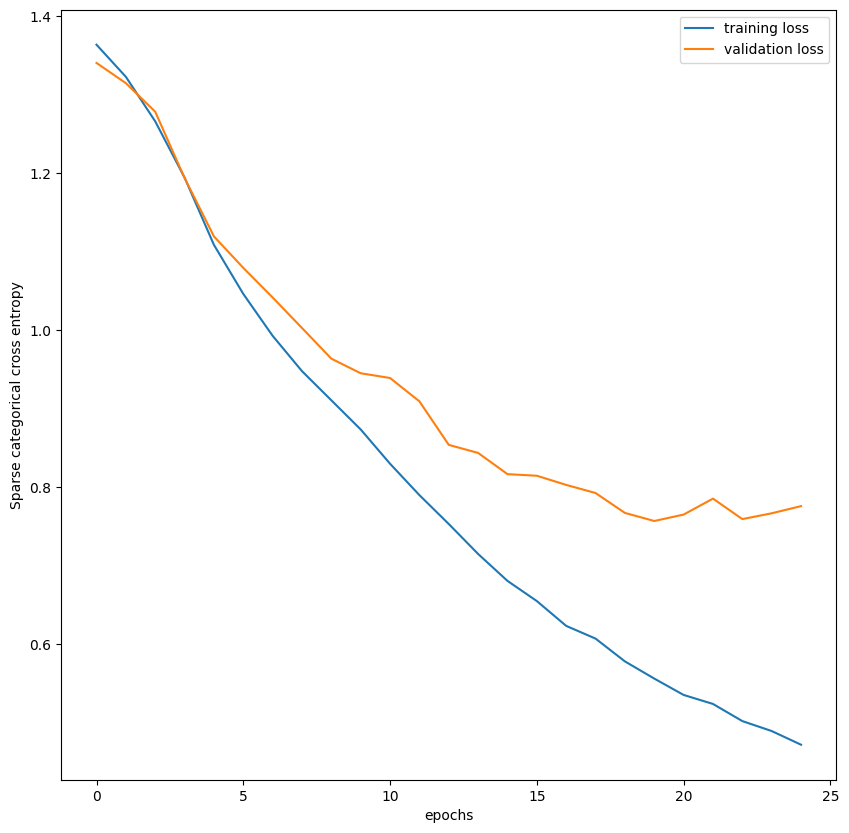

In [16]:
#GRU layers
tf.keras.backend.clear_session()
tf.random.set_seed(4362)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1], X.shape[2])),
    GRU(32, return_sequences=True),
    GRU(32),
    Dense(4, activation = "softmax")
])
model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_gru",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint_cb, early_cb])

model = tf.keras.models.load_model("turbinemode_gru")
print(f"Validation Accuracy RNN: {model.evaluate(validation_dataset)[1]:.2f}")

# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

### Network with Conv1D and GRU layers
In this network a two Conv1D layers followed by two GRU layers are used.
Training with only GRU layers can be computationally intensive when applied to long time-series data. Conv1D layers are applied to subsample the input signal before passing it to the GRU layers.
The accuracy on the validation dataset for this network is 0.81. 
This is an improvement over using only GRU layers.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5000, 20)          980       
                                                                 
 conv1d_1 (Conv1D)           (None, 5000, 20)          6420      
                                                                 
 conv1d_2 (Conv1D)           (None, 5000, 20)          4820      
                                                                 
 gru (GRU)                   (None, 5000, 32)          5184      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 19,872
Trainable params: 19,872
Non-traina

75/75 [==============================] - 30s 337ms/step - loss: 1.3220 - accuracy: 0.3725 - val_loss: 1.1961 - val_accuracy: 0.4588
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 1.0628 - accuracy: 0.5425

75/75 [==============================] - 24s 317ms/step - loss: 1.0628 - accuracy: 0.5425 - val_loss: 0.9316 - val_accuracy: 0.5875
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.8174 - accuracy: 0.6742

75/75 [==============================] - 23s 311ms/step - loss: 0.8174 - accuracy: 0.6742 - val_loss: 0.7626 - val_accuracy: 0.6775
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.7621

75/75 [==============================] - 25s 335ms/step - loss: 0.6118 - accuracy: 0.7621 - val_loss: 0.6267 - val_accuracy: 0.7588
Epoch 5/100
75/75 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.7929

75/75 [==============================] - 24s 321ms/step - loss: 0.5330 - accuracy: 0.7929 - val_loss: 0.5802 - val_accuracy: 0.7650
Epoch 6/100
75/75 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8254

75/75 [==============================] - 25s 331ms/step - loss: 0.4380 - accuracy: 0.8254 - val_loss: 0.5671 - val_accuracy: 0.7700
Epoch 7/100
75/75 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8554

75/75 [==============================] - 24s 315ms/step - loss: 0.3790 - accuracy: 0.8554 - val_loss: 0.5181 - val_accuracy: 0.7975
Epoch 8/100
75/75 [==============================] - 17s 221ms/step - loss: 0.3438 - accuracy: 0.8646 - val_loss: 0.5206 - val_accuracy: 0.7850
Epoch 9/100
75/75 [==============================] - 17s 221ms/step - loss: 0.3209 - accuracy: 0.8729 - val_loss: 0.5182 - val_accuracy: 0.7812
Epoch 10/100
75/75 [==============================] - 18s 238ms/step - loss: 0.2843 - accuracy: 0.8900 - val_loss: 0.5352 - val_accuracy: 0.7837
Epoch 11/100
75/75 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.8938

75/75 [==============================] - 24s 323ms/step - loss: 0.2571 - accuracy: 0.8938 - val_loss: 0.5001 - val_accuracy: 0.7937
Epoch 12/100
75/75 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9004

75/75 [==============================] - 24s 320ms/step - loss: 0.2446 - accuracy: 0.9004 - val_loss: 0.4958 - val_accuracy: 0.8138
Epoch 13/100
75/75 [==============================] - 17s 222ms/step - loss: 0.2216 - accuracy: 0.9112 - val_loss: 0.5188 - val_accuracy: 0.8000
Epoch 14/100
75/75 [==============================] - 18s 239ms/step - loss: 0.2094 - accuracy: 0.9129 - val_loss: 0.5379 - val_accuracy: 0.7950
Epoch 15/100
75/75 [==============================] - 17s 221ms/step - loss: 0.2039 - accuracy: 0.9125 - val_loss: 0.5424 - val_accuracy: 0.7912
Epoch 16/100
75/75 [==============================] - 17s 231ms/step - loss: 0.1957 - accuracy: 0.9208 - val_loss: 0.7050 - val_accuracy: 0.7525
Epoch 17/100
25/25 [==============================] - 3s 86ms/step - loss: 0.4958 - accuracy: 0.8138
Validation Accuracy RNN: 0.81


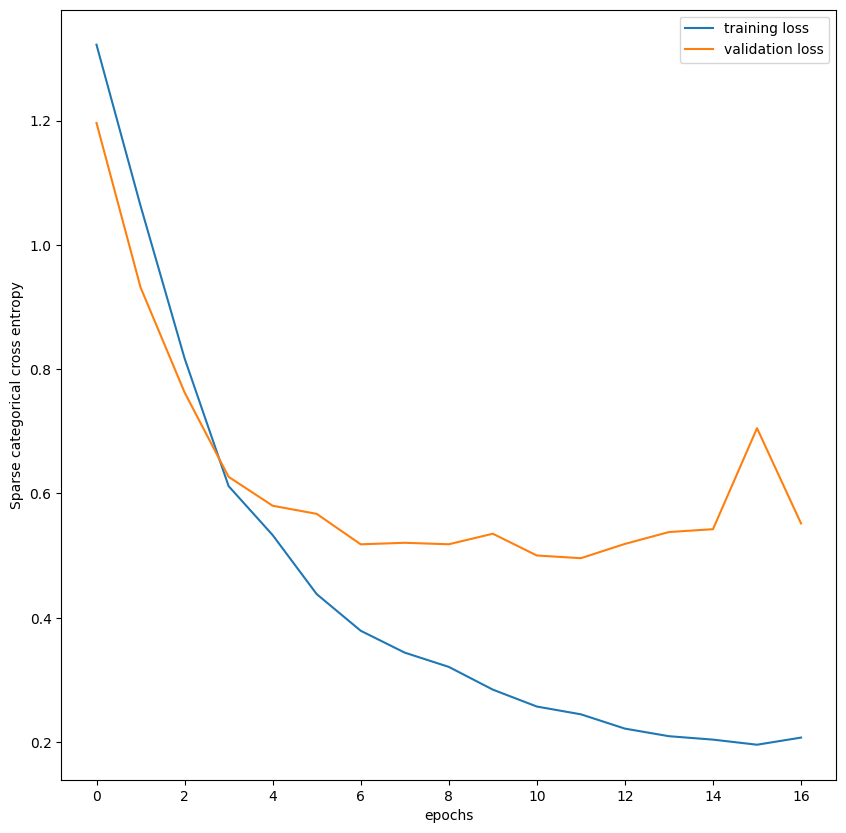

In [17]:
#Combination of conv1D and GRU layers
tf.keras.backend.clear_session()
tf.random.set_seed(4362)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1], X.shape[2])),
    Conv1D(20, 24, activation="relu", padding="same"),
    Conv1D(20, 16, activation="relu", padding="same"),
    Conv1D(20, 12, activation="relu", padding="same"),
    GRU(32, return_sequences=True),
    GRU(16),
    Dense(4, activation = "softmax")
])
model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_ccgg",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint_cb, early_cb])

model = tf.keras.models.load_model("turbinemode_ccgg")
print(f"Validation Accuracy RNN: {model.evaluate(validation_dataset)[1]:.2f}")

# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

## Q4
Conv1D layers are useful to extract local information or features from neighbouring time points in the time series signal. They are also computationally less intensive in comparison to RNNs. An example business application where Conv1D layers can be used is in analyzing user feedback regarding a newly launched product from user comments or tweets. In this case, specific patterns of words that indicate positivity (e.g. satisfied, good, happy etc.) or negativity (dissatisfied, unhappy etc.) need to be extracted from the text. This process should also be translation invariant, meaning that the pattern can occur at any location in the comment. As a Conv1D filter applies the same transformation on every patch that it processes, translational invariance is guaranteed.

On the other hand RNNs capture both short and longterm dependencies in the data.In applications where the order in which the input appears is relevant to predicting the output, recurrent layers are useful as they store a state of the past in their "memory" which is propagated and used for prediction at the next time step. A good example for the use of RNNs would be predicting the stock price. Stock price fluctuations at a certain moment have some connection to previous trends and an RNN is able to capture these trends.

Furthermore, in many applications it is common to use Conv1D layers first followed by Recurrent layers. The Conv1D layers are a computationally cheap way to subsample the signal and thus reduce the input vector's length as we move towards higher layers.

## Q5
The fault in a particular sensor can be a localized anomalies in time. In order to detect the fault, it may not be necessary to analyze the sensor readings over the entire recording time but look for specific local patterns in the readings such as correlations between readings from adjacent time points. By converting the timeseries signal into an image, these local patterns are now embedded spatially between adjacent pixels. CNNs are good at extracting these spatial patterns and can be used to find these small anomalies and faults in the presence of noise. For this reason, CNNs may outperform RNNS in this case.

## Q6
### Converting timeseries data to images

In [18]:
# make copies of the dataset that we used earlier
train_dataset_cnn = copy.deepcopy(X_train_dataset)
Y_train_cnn = Y_train
print("Shape of the (timeseries) training dataset X: {}".format(train_dataset_cnn.shape))
print("Shape of the (timeseries) training dataset Y: {}".format(Y_train_cnn.shape))

val_dataset_cnn = copy.deepcopy(X_val_dataset)
Y_val_cnn = Y_val
print("Shape of the (timeseries) validation dataset X: {}".format(val_dataset_cnn.shape))
print("Shape of the (timeseries) validation dataset Y: {}".format(Y_val_cnn.shape))

test_dataset_cnn = copy.deepcopy(X_test_dataset)
Y_test_cnn = Y_test
print("Shape of the (timeseries) test dataset X: {}".format(test_dataset_cnn.shape))
print("Shape of the (timeseries) test dataset Y: {}".format(Y_test_cnn.shape))

# Create images from these datasets
# We have 5000 sensor readings per recording.

def create_images(dataset):
  split_per_sensor = 50
  num_sensors = 2
  img_width = split_per_sensor * num_sensors
  img_height = dataset.shape[1] // split_per_sensor
  num_images = dataset.shape[0]
  # create an images of shape 4000, 100, 100, 1
  images = np.zeros((num_images, img_height, img_width, 1))
  # for each image
  for img_id in range(0, num_images):
    # for each row of the image
    for j in range(img_height):
      # get start and end IDs
      start_id = j * split_per_sensor
      end_id = start_id + split_per_sensor

      # copy from first sensor
      images[img_id, j, 0:split_per_sensor, 0] = dataset[img_id, start_id:end_id, 0]
      # copy from second sensor
      images[img_id, j, split_per_sensor:, 0] = dataset[img_id, start_id:end_id, 1]

  return images

X_train_cnn = create_images(train_dataset_cnn)
X_val_cnn = create_images(val_dataset_cnn)
X_test_cnn = create_images(test_dataset_cnn)
print("-------------------------------")
print("Shape of the (images) training dataset X: {}".format(X_train_cnn.shape))
print("Shape of the (images) validation dataset X: {}".format(X_val_cnn.shape))
print("Shape of the (images) test dataset X: {}".format(X_test_cnn.shape))

Shape of the (timeseries) training dataset X: (2400, 5000, 2)
Shape of the (timeseries) training dataset Y: (2400,)
Shape of the (timeseries) validation dataset X: (800, 5000, 2)
Shape of the (timeseries) validation dataset Y: (800,)
Shape of the (timeseries) test dataset X: (800, 5000, 2)
Shape of the (timeseries) test dataset Y: (800,)
-------------------------------
Shape of the (images) training dataset X: (2400, 100, 100, 1)
Shape of the (images) validation dataset X: (800, 100, 100, 1)
Shape of the (images) test dataset X: (800, 100, 100, 1)


## Q7
### Implementing the network from the paper (Fig. 12).
The accuracy on the validation dataset for this network is 0.861

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                        

75/75 [==============================] - 6s 48ms/step - loss: 1.0770 - accuracy: 0.6104 - val_loss: 0.6286 - val_accuracy: 0.7412
Epoch 2/100
73/75 [============================>.] - ETA: 0s - loss: 0.3170 - accuracy: 0.8827

75/75 [==============================] - 3s 36ms/step - loss: 0.3162 - accuracy: 0.8833 - val_loss: 0.3927 - val_accuracy: 0.8712
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9142

75/75 [==============================] - 3s 39ms/step - loss: 0.2148 - accuracy: 0.9142 - val_loss: 0.3488 - val_accuracy: 0.8612
Epoch 4/100
75/75 [==============================] - 2s 23ms/step - loss: 0.1482 - accuracy: 0.9408 - val_loss: 0.3561 - val_accuracy: 0.8675
Epoch 5/100
75/75 [==============================] - 2s 23ms/step - loss: 0.0933 - accuracy: 0.9629 - val_loss: 0.4804 - val_accuracy: 0.8438
Epoch 6/100
75/75 [==============================] - 2s 23ms/step - loss: 0.0793 - accuracy: 0.9688 - val_loss: 0.5537 - val_accuracy: 0.8388
Epoch 7/100
75/75 [==============================] - 2s 23ms/step - loss: 0.0670 - accuracy: 0.9733 - val_loss: 0.4279 - val_accuracy: 0.8662
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3488 - accuracy: 0.8612
Validation Accuracy CNN: 0.861


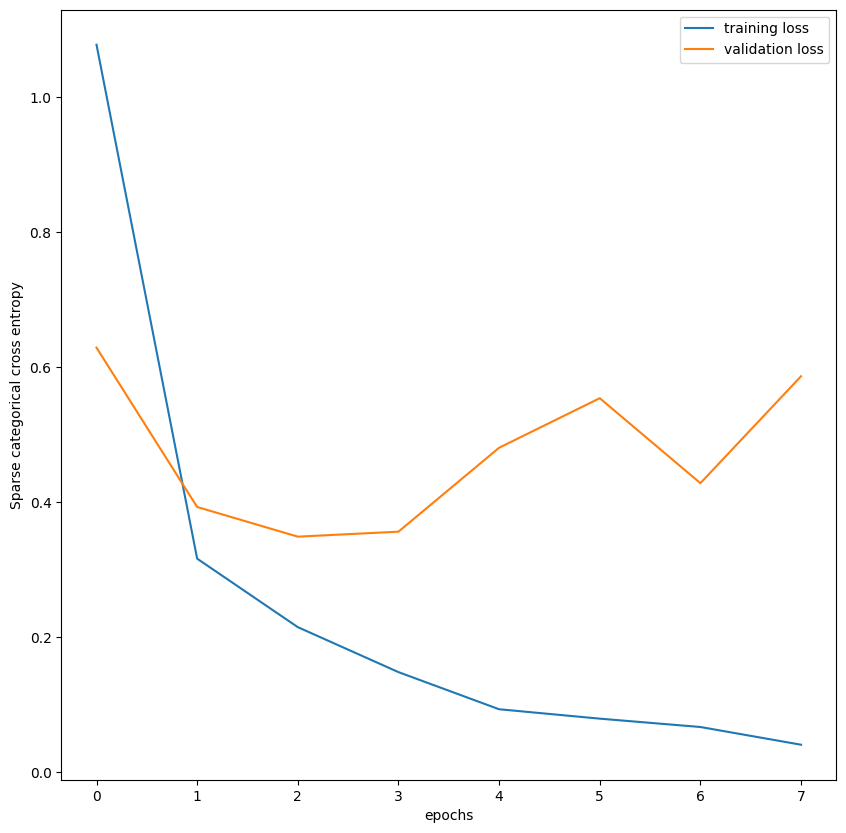

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(52345)
np.random.seed(231)
random.seed(3214)
# Define the model: 3 Conv2D layers
model = tf.keras.Sequential([
    tf.keras.Input(shape=(100, 100, 1)),
    Conv2D(32, kernel_size=(3,3)),
    Conv2D(32, kernel_size=(3,3)),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3,3), activation="relu"),
    MaxPooling2D(pool_size=(3,3)),
    Flatten(),
    Dense(4, activation = "softmax")
    ])
model.summary()

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_cnn2D",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])

# Training
history = model.fit(X_train_cnn, 
                    Y_train_cnn,
                    epochs=100,
                    validation_data=(X_val_cnn, Y_val_cnn),
                    callbacks=[checkpoint_cb, early_cb])

model.save("task7.h5")

# Evaluation
model = tf.keras.models.load_model("turbinemode_cnn2D")
print(f"Validation Accuracy CNN: {model.evaluate(X_val_cnn, Y_val_cnn)[1]:.3f}")

# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

## Q8
### Improving the model from Q7.
#### Increase number of CNN Layers

We increase the nonlinearity in the model by increasing the number of CNN layers. This helps capture higher level features in the images.

We use the keras_tuner to tune the numebr of filters in each layer.

The accuracy on the validation dataset for this model is 0.871.

104
56
19
14
0.00515143709153991
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 1.2492 - accuracy: 0.4121

75/75 [==============================] - 7s 62ms/step - loss: 1.2492 - accuracy: 0.4121 - val_loss: 1.1058 - val_accuracy: 0.5025
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.9985 - accuracy: 0.5654

75/75 [==============================] - 4s 58ms/step - loss: 0.9985 - accuracy: 0.5654 - val_loss: 0.8628 - val_accuracy: 0.6450
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.6733

75/75 [==============================] - 4s 55ms/step - loss: 0.7846 - accuracy: 0.6733 - val_loss: 0.6333 - val_accuracy: 0.7450
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.7833

75/75 [==============================] - 4s 57ms/step - loss: 0.5598 - accuracy: 0.7833 - val_loss: 0.5078 - val_accuracy: 0.8100
Epoch 5/100
75/75 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8383

75/75 [==============================] - 5s 60ms/step - loss: 0.4091 - accuracy: 0.8383 - val_loss: 0.4385 - val_accuracy: 0.8400
Epoch 6/100
75/75 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8546

75/75 [==============================] - 4s 57ms/step - loss: 0.3613 - accuracy: 0.8546 - val_loss: 0.3415 - val_accuracy: 0.8763
Epoch 7/100
75/75 [==============================] - 3s 41ms/step - loss: 0.3127 - accuracy: 0.8733 - val_loss: 0.3730 - val_accuracy: 0.8712
Epoch 8/100
75/75 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.8758

75/75 [==============================] - 4s 57ms/step - loss: 0.2880 - accuracy: 0.8758 - val_loss: 0.3362 - val_accuracy: 0.8725
Epoch 9/100
75/75 [==============================] - 3s 43ms/step - loss: 0.2678 - accuracy: 0.8979 - val_loss: 0.3671 - val_accuracy: 0.8712
Epoch 10/100
75/75 [==============================] - 3s 43ms/step - loss: 0.2709 - accuracy: 0.8813 - val_loss: 0.3691 - val_accuracy: 0.8650
Epoch 11/100
75/75 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.8900

75/75 [==============================] - 4s 60ms/step - loss: 0.2720 - accuracy: 0.8900 - val_loss: 0.3321 - val_accuracy: 0.8712
Epoch 12/100
75/75 [==============================] - 3s 41ms/step - loss: 0.2708 - accuracy: 0.8858 - val_loss: 0.3629 - val_accuracy: 0.8425
Epoch 13/100
75/75 [==============================] - 3s 43ms/step - loss: 0.2732 - accuracy: 0.8896 - val_loss: 0.3645 - val_accuracy: 0.8587
Epoch 14/100
75/75 [==============================] - 3s 43ms/step - loss: 0.2440 - accuracy: 0.8942 - val_loss: 0.3645 - val_accuracy: 0.8813
Epoch 15/100
75/75 [==============================] - 3s 42ms/step - loss: 0.2563 - accuracy: 0.8925 - val_loss: 0.3714 - val_accuracy: 0.8687
Epoch 16/100
25/25 [==============================] - 0s 8ms/step - loss: 0.3321 - accuracy: 0.8712
Validation Accuracy CNN: 0.871


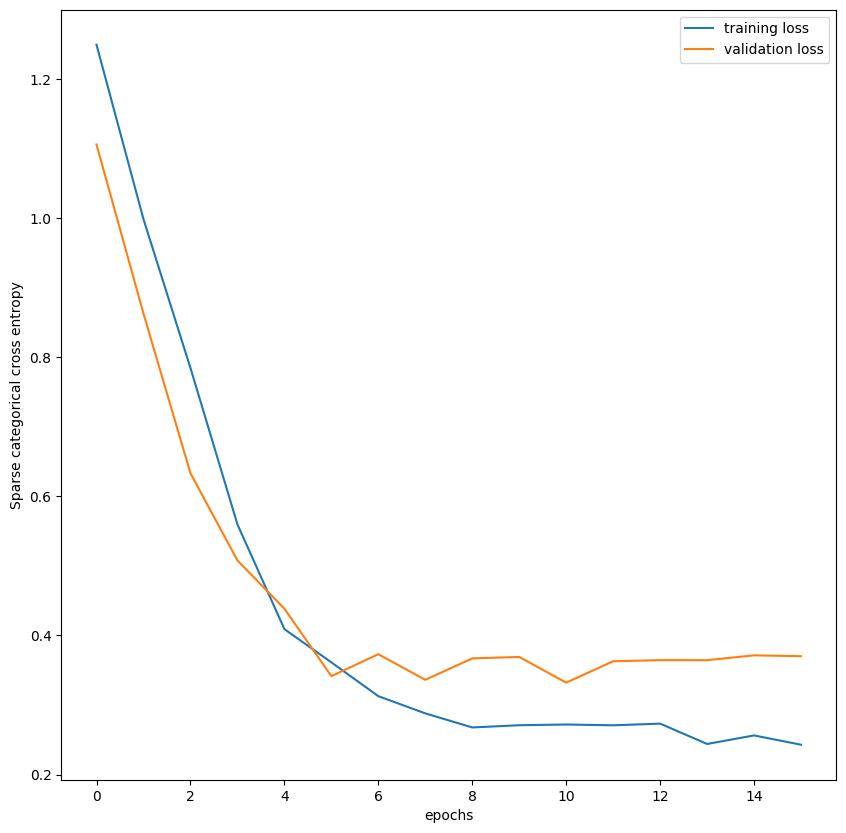

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(3234)
np.random.seed(53)
random.seed(31543)

# Define the model
def build(hp):
  # number of hidden untis per layer
  num_units_1 = hp.Int('num_units_l1', min_value=64, max_value=128)
  num_units_2 = hp.Int('num_units_l2', min_value=32, max_value=64)
  num_units_3 = hp.Int('num_units_l3', min_value=16, max_value=32)
  num_units_4 = hp.Int('num_units_l4', min_value=8, max_value=16)
  initial_lr = hp.Float('initial_lr', min_value=0.001, max_value=0.01, sampling="log")

  model=tf.keras.Sequential([
      tf.keras.Input(shape=(100, 100, 1)),
      Conv2D(num_units_1, kernel_size=(5,5), activation="relu", padding="valid"),
      Conv2D(num_units_2, kernel_size=(3,3), activation="relu", padding="valid"),
      MaxPooling2D(pool_size=(3,3)),
      Dropout(0.2),
      Conv2D(num_units_3, kernel_size=(3,3), activation="relu", padding="valid"),
      MaxPooling2D(pool_size=(3,3)),
      Conv2D(num_units_4, kernel_size=(3,3), activation="relu", padding="valid"),
      MaxPooling2D(pool_size=(3,3)),
      Flatten(),
      Dense(4, activation = "softmax")
    ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  return model

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_cnn2D_improved",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Tuning
tuner = kt.Hyperband(build,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='logs',
                     project_name='dl')
tuner.search(X_train_cnn, Y_train_cnn, validation_data=(X_val_cnn, Y_val_cnn))

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps['num_units_l1'])
print(best_hps['num_units_l2'])
print(best_hps['num_units_l3'])
print(best_hps['num_units_l4'])
print(best_hps['initial_lr'])

best_model = tuner.hypermodel.build(best_hps)

# Training
history = best_model.fit(X_train_cnn, 
                    Y_train_cnn,
                    epochs=100,
                    validation_data=(X_val_cnn, Y_val_cnn),
                    callbacks=[checkpoint_cb, early_cb])

# Evaluation
model = tf.keras.models.load_model("turbinemode_cnn2D_improved")
print(f"Validation Accuracy CNN: {model.evaluate(X_val_cnn, Y_val_cnn)[1]:.3f}")

# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

### Add Batch Normalization and Dropout
We further added Batch normalization and dropout to prevent overfitting.
Along with this we also added a learning rate scheduler.  
The accuracy on the validation dataset for this model is 0.873.

Trial 30 Complete [00h 00m 34s]
val_accuracy: 0.8587499856948853

Best val_accuracy So Far: 0.8774999976158142
Total elapsed time: 00h 07m 49s
103
58
21
0.0002795460351385751
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 1.4518 - accuracy: 0.4479

75/75 [==============================] - 7s 64ms/step - loss: 1.4518 - accuracy: 0.4479 - val_loss: 1.3234 - val_accuracy: 0.3525 - lr: 2.7955e-04
Epoch 2/100
75/75 [==============================] - 3s 34ms/step - loss: 0.6821 - accuracy: 0.7321 - val_loss: 1.3456 - val_accuracy: 0.3162 - lr: 2.7955e-04
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.4476 - accuracy: 0.8317

75/75 [==============================] - 4s 52ms/step - loss: 0.4476 - accuracy: 0.8317 - val_loss: 1.2858 - val_accuracy: 0.3663 - lr: 2.7955e-04
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8867

75/75 [==============================] - 5s 63ms/step - loss: 0.3131 - accuracy: 0.8867 - val_loss: 1.0074 - val_accuracy: 0.5612 - lr: 2.7955e-04
Epoch 5/100
75/75 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8979

75/75 [==============================] - 4s 52ms/step - loss: 0.2694 - accuracy: 0.8979 - val_loss: 0.7262 - val_accuracy: 0.7362 - lr: 2.7955e-04
Epoch 6/100
75/75 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9062

75/75 [==============================] - 4s 53ms/step - loss: 0.2266 - accuracy: 0.9062 - val_loss: 0.3916 - val_accuracy: 0.8763 - lr: 2.7955e-04
Epoch 7/100
75/75 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9271

75/75 [==============================] - 4s 58ms/step - loss: 0.1802 - accuracy: 0.9271 - val_loss: 0.3318 - val_accuracy: 0.8763 - lr: 2.7955e-04
Epoch 8/100
75/75 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9413

75/75 [==============================] - 4s 52ms/step - loss: 0.1608 - accuracy: 0.9413 - val_loss: 0.3145 - val_accuracy: 0.8725 - lr: 2.7955e-04
Epoch 9/100
75/75 [==============================] - 2s 33ms/step - loss: 0.1453 - accuracy: 0.9429 - val_loss: 0.3350 - val_accuracy: 0.8275 - lr: 2.7955e-04
Epoch 10/100
75/75 [==============================] - 3s 33ms/step - loss: 0.1342 - accuracy: 0.9467 - val_loss: 0.3528 - val_accuracy: 0.8750 - lr: 2.7955e-04
Epoch 11/100
75/75 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9604
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00022363683674484492.
75/75 [==============================] - 3s 34ms/step - loss: 0.1063 - accuracy: 0.9604 - val_loss: 0.3538 - val_accuracy: 0.8313 - lr: 2.7955e-04
Epoch 12/100
75/75 [==============================] - 3s 34ms/step - loss: 0.0907 - accuracy: 0.9679 - val_loss: 0.3488 - val_accuracy: 0.8600 - lr: 2.2364e-04
Epoch 13/100
75/75 [==============================] -

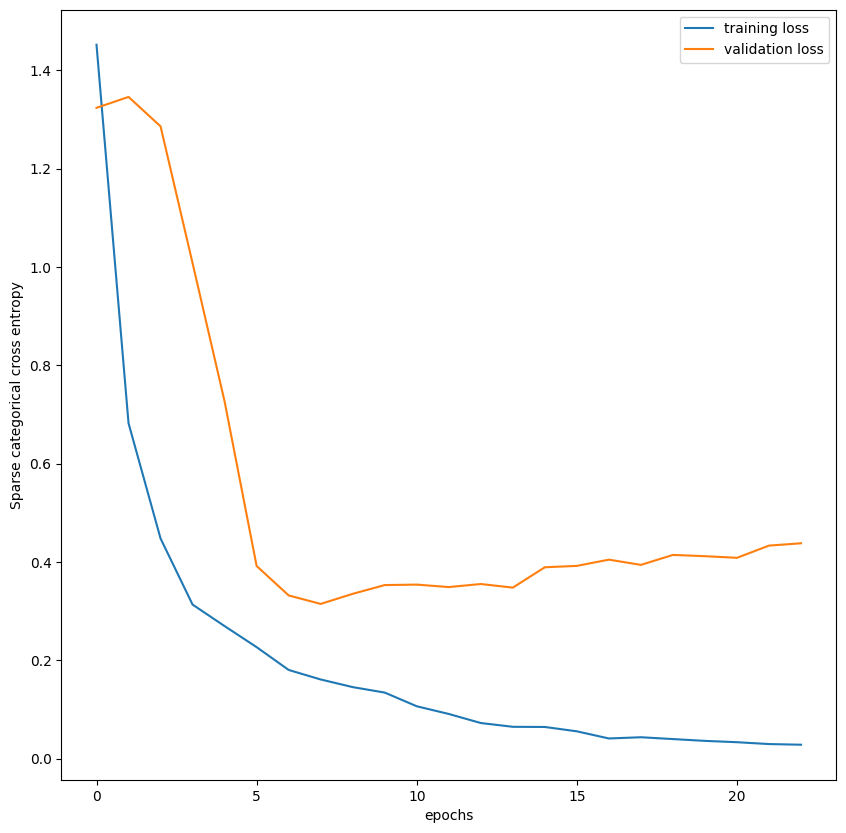

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(6412343)

# Define the model
def build(hp):
  # number of hidden untis per layer
  num_units_1 = hp.Int('num_units_l1', min_value=64, max_value=128)
  num_units_2 = hp.Int('num_units_l2', min_value=32, max_value=65)
  num_units_3 = hp.Int('num_units_l3', min_value=16, max_value=32)
  initial_lr = hp.Float('initial_lr', min_value=0.00001, max_value=0.01, sampling="log")

  model=tf.keras.Sequential([
      tf.keras.Input(shape=(100, 100, 1)),
      # BatchNormalization(),
      Conv2D(num_units_1, kernel_size=(5,5), activation="relu", padding="valid"),
      BatchNormalization(),
      MaxPooling2D(pool_size=(3,3)),
      Dropout(0.1),

      Conv2D(num_units_2, kernel_size=(3,3), activation="relu", padding="valid"),
      BatchNormalization(),
      MaxPooling2D(pool_size=(3,3)),
      Dropout(0.1),
      
      Conv2D(num_units_3, kernel_size=(3,3), activation="relu", padding="valid"),
      Flatten(),
      Dense(4, activation = "softmax")
    ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  return model

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_cnn2D_improved_3",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
lr_red_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.8, min_lr=1e-5)

# Tuning
tuner = kt.Hyperband(build,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='logs',
                     project_name='dl' + str(datetime.datetime.now().timestamp()))
tuner.search(X_train_cnn, Y_train_cnn, validation_data=(X_val_cnn, Y_val_cnn))

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps['num_units_l1'])
print(best_hps['num_units_l2'])
print(best_hps['num_units_l3'])
print(best_hps['initial_lr'])

best_model = tuner.hypermodel.build(best_hps)

# Training
history = best_model.fit(X_train_cnn, 
                    Y_train_cnn,
                    epochs=100,
                    validation_data=(X_val_cnn, Y_val_cnn),
                    callbacks=[checkpoint_cb, lr_red_callback, early_cb])

# Evaluation
model = tf.keras.models.load_model("turbinemode_cnn2D_improved_3")
print(f"Validation Accuracy CNN: {model.evaluate(X_val_cnn, Y_val_cnn)[1]:.3f}")

model.save('task8.h5')

# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

### Using pretrained MobileNetV2 with Imagenet weights.
A pretrained mobilenet is loaded with weights initialized from Imagenet training. These weights are frozen. Dense layers are added on top of this.

The accuracy on the validation dataset is 0.819

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 32000)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4096128   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 4)                 68

75/75 [==============================] - 29s 327ms/step - loss: 1.9047 - accuracy: 0.4183 - val_loss: 1.4011 - val_accuracy: 0.4712 - lr: 0.0010
Epoch 2/50
73/75 [============================>.] - ETA: 0s - loss: 0.9327 - accuracy: 0.6314

75/75 [==============================] - 24s 328ms/step - loss: 0.9297 - accuracy: 0.6313 - val_loss: 0.9337 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.6708

75/75 [==============================] - 24s 326ms/step - loss: 0.7977 - accuracy: 0.6708 - val_loss: 0.7176 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 3s 34ms/step - loss: 0.6254 - accuracy: 0.7504 - val_loss: 0.7882 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/50
74/75 [============================>.] - ETA: 0s - loss: 0.6416 - accuracy: 0.7441

75/75 [==============================] - 24s 319ms/step - loss: 0.6404 - accuracy: 0.7442 - val_loss: 0.6184 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 2s 33ms/step - loss: 0.5250 - accuracy: 0.7933 - val_loss: 0.7938 - val_accuracy: 0.7088 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8475

75/75 [==============================] - 25s 334ms/step - loss: 0.4077 - accuracy: 0.8475 - val_loss: 0.5262 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 8/50
73/75 [============================>.] - ETA: 0s - loss: 0.3554 - accuracy: 0.8724

75/75 [==============================] - 24s 324ms/step - loss: 0.3512 - accuracy: 0.8754 - val_loss: 0.5147 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 9/50
75/75 [==============================] - 2s 32ms/step - loss: 0.2865 - accuracy: 0.9004 - val_loss: 0.6768 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 10/50
75/75 [==============================] - 2s 33ms/step - loss: 0.4001 - accuracy: 0.8317 - val_loss: 0.6216 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 11/50
75/75 [==============================] - 2s 32ms/step - loss: 0.4722 - accuracy: 0.8133 - val_loss: 0.6034 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 12/50
75/75 [==============================] - 3s 35ms/step - loss: 0.2481 - accuracy: 0.9038 - val_loss: 0.5398 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 13/50
74/75 [============================>.] - ETA: 0s - loss: 0.2127 - accuracy: 0.9274
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 [==============================] - 2s 33ms/step - loss: 0.

75/75 [==============================] - 24s 319ms/step - loss: 0.1532 - accuracy: 0.9438 - val_loss: 0.4711 - val_accuracy: 0.8188 - lr: 5.0000e-04
Epoch 16/50
75/75 [==============================] - 2s 32ms/step - loss: 0.1297 - accuracy: 0.9596 - val_loss: 0.4806 - val_accuracy: 0.8050 - lr: 5.0000e-04
Epoch 17/50
75/75 [==============================] - 2s 32ms/step - loss: 0.1177 - accuracy: 0.9654 - val_loss: 0.5098 - val_accuracy: 0.8100 - lr: 5.0000e-04
Epoch 18/50
75/75 [==============================] - 3s 33ms/step - loss: 0.1163 - accuracy: 0.9608 - val_loss: 0.4852 - val_accuracy: 0.8188 - lr: 5.0000e-04
Epoch 19/50
75/75 [==============================] - 2s 33ms/step - loss: 0.1197 - accuracy: 0.9588 - val_loss: 0.6135 - val_accuracy: 0.7450 - lr: 5.0000e-04
Epoch 20/50
73/75 [============================>.] - ETA: 0s - loss: 0.1168 - accuracy: 0.9606
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
75/75 [==============================] - 2s

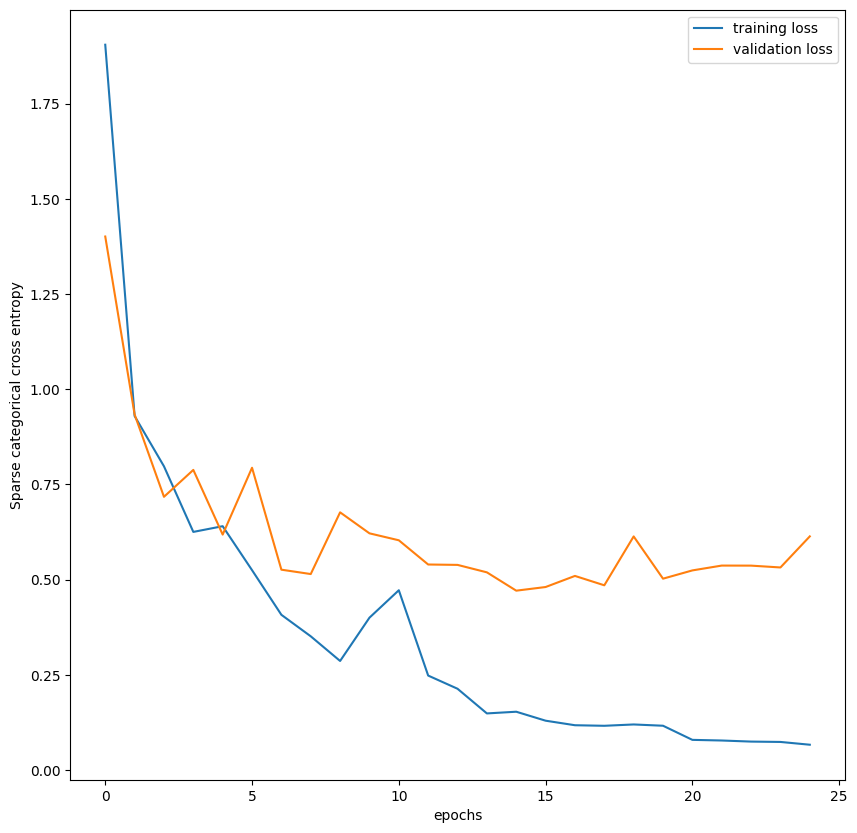

In [24]:

# using pretrained MobileNetV2 network
mobilenetv2 = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))
mobilenetv2.trainable=False

tf.random.set_seed(18)

# preprocess the images
X_train_mb = tf.keras.applications.mobilenet.preprocess_input(tf.repeat(tf.image.resize(X_train_cnn, [160, 160]), 3, axis=-1))
X_val_mb = tf.keras.applications.mobilenet.preprocess_input(tf.repeat(tf.image.resize(X_val_cnn, [160, 160]), 3, axis=-1))
X_test_mb = tf.keras.applications.mobilenet.preprocess_input(tf.repeat(tf.image.resize(X_test_cnn, [160, 160]), 3, axis=-1))

model = tf.keras.Sequential([
    tf.keras.Input(shape=(160, 160, 3)),
    mobilenetv2,
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(16, activation="relu"),
    Dense(4, activation="softmax"),
])

model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_mobilenetv2",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_red_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=1e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                #  beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])

history = model.fit(X_train_mb, 
                    Y_train_cnn,
                    epochs=50,
                    validation_data=(X_val_mb, Y_val_cnn),
                    callbacks=[checkpoint_cb
                               , early_cb
                               , lr_red_callback])

model = tf.keras.models.load_model("turbinemode_mobilenetv2")
print(f"Validation Accuracy CNN: {model.evaluate(X_val_mb, Y_val_cnn)[1]:.3f}")

# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

## Using pretrained VGG-19 with Imagenet weights.  
A pretrained VGG network is loaded with weights initialized from Imagenet training. These weights are frozen. Dense layers are added on top of this.

The accuracy on the validation dataset is 0.827

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 21,631,188
Trainable params: 1,606,804
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/80
75/75 [==================

75/75 [==============================] - 24s 262ms/step - loss: 1.2374 - accuracy: 0.4433 - val_loss: 0.9827 - val_accuracy: 0.5987
Epoch 2/80
75/75 [==============================] - ETA: 0s - loss: 0.8213 - accuracy: 0.6787

75/75 [==============================] - 20s 272ms/step - loss: 0.8213 - accuracy: 0.6787 - val_loss: 0.7672 - val_accuracy: 0.7100
Epoch 3/80
75/75 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7958

75/75 [==============================] - 19s 255ms/step - loss: 0.6043 - accuracy: 0.7958 - val_loss: 0.7093 - val_accuracy: 0.7100
Epoch 4/80
75/75 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.8413

75/75 [==============================] - 20s 273ms/step - loss: 0.4660 - accuracy: 0.8413 - val_loss: 0.5814 - val_accuracy: 0.7925
Epoch 5/80
75/75 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8783

75/75 [==============================] - 19s 259ms/step - loss: 0.3555 - accuracy: 0.8783 - val_loss: 0.5708 - val_accuracy: 0.7700
Epoch 6/80
75/75 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.8958

75/75 [==============================] - 20s 262ms/step - loss: 0.2958 - accuracy: 0.8958 - val_loss: 0.5092 - val_accuracy: 0.8100
Epoch 7/80
75/75 [==============================] - 16s 216ms/step - loss: 0.2515 - accuracy: 0.9121 - val_loss: 0.5490 - val_accuracy: 0.7887
Epoch 8/80
75/75 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9271

75/75 [==============================] - 21s 281ms/step - loss: 0.2087 - accuracy: 0.9271 - val_loss: 0.4755 - val_accuracy: 0.8075
Epoch 9/80
75/75 [==============================] - 16s 216ms/step - loss: 0.1623 - accuracy: 0.9517 - val_loss: 0.5647 - val_accuracy: 0.7825
Epoch 10/80
75/75 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9571

75/75 [==============================] - 20s 262ms/step - loss: 0.1405 - accuracy: 0.9571 - val_loss: 0.4667 - val_accuracy: 0.8275
Epoch 11/80
75/75 [==============================] - 16s 216ms/step - loss: 0.1008 - accuracy: 0.9750 - val_loss: 0.4935 - val_accuracy: 0.8150
Epoch 12/80
75/75 [==============================] - 16s 216ms/step - loss: 0.0819 - accuracy: 0.9846 - val_loss: 0.5043 - val_accuracy: 0.8413
Epoch 13/80
75/75 [==============================] - 16s 217ms/step - loss: 0.0593 - accuracy: 0.9908 - val_loss: 0.5157 - val_accuracy: 0.8375
Epoch 14/80
75/75 [==============================] - 16s 216ms/step - loss: 0.0485 - accuracy: 0.9946 - val_loss: 0.5352 - val_accuracy: 0.8388
Epoch 15/80
75/75 [==============================] - 17s 232ms/step - loss: 0.0378 - accuracy: 0.9958 - val_loss: 0.8369 - val_accuracy: 0.8087
Epoch 16/80
75/75 [==============================] - 17s 231ms/step - loss: 0.0337 - accuracy: 0.9975 - val_loss: 0.5504 - val_accuracy: 0.8438
Epoc

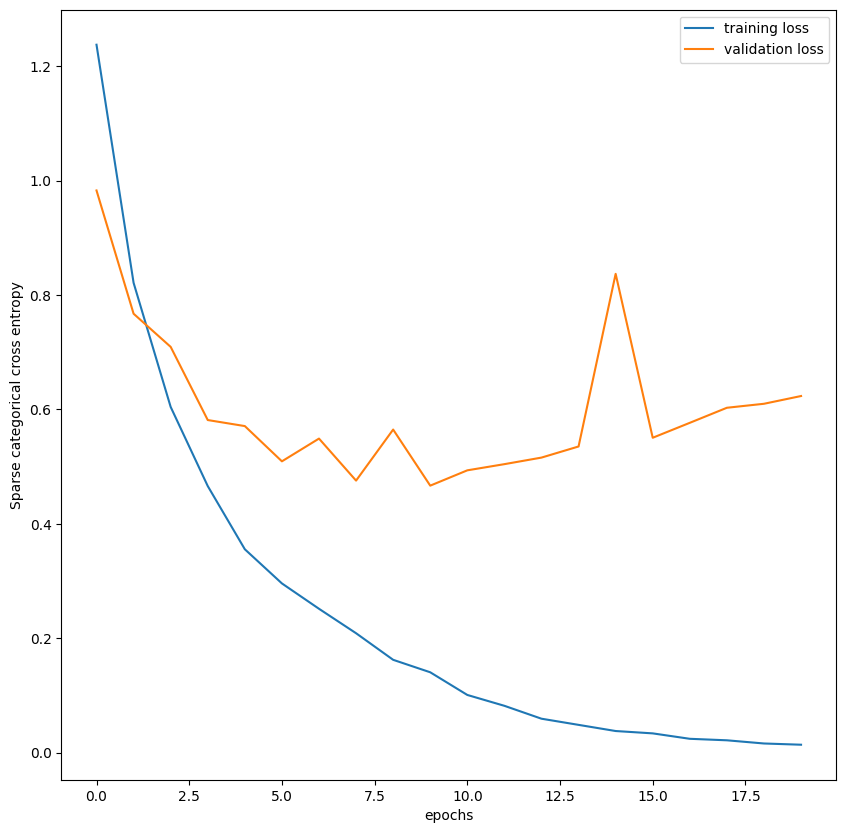

In [27]:
# using pretrained VGG network
VGG = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
VGG.trainable=False

tf.keras.backend.clear_session()

tf.random.set_seed(29)

# preprocess the images
X_train_mb = tf.repeat(tf.image.resize(X_train_cnn, [224, 224]), 3, axis=-1)
X_val_mb = tf.repeat(tf.image.resize(X_val_cnn, [224, 224]), 3, axis=-1)
X_test_mb = tf.repeat(tf.image.resize(X_test_cnn, [224, 224]), 3, axis=-1)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    VGG,
    # Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid'),
    Flatten(),
    # GlobalAveragePooling2D(),
    # Dense(256, activation="relu"),
    # Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(16, activation="relu"),
    Dense(4, activation="softmax"),
])

model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("turbinemode_VGG",save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# lr_red_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=1e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                #  beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])

history = model.fit(X_train_mb, 
                    Y_train_cnn,
                    epochs=80,
                    validation_data=(X_val_mb, Y_val_cnn),
                    callbacks=[checkpoint_cb
                               , early_cb
                              #  , lr_red_callback
                    ])
model = tf.keras.models.load_model("turbinemode_VGG")
print(f"Validation Accuracy CNN: {model.evaluate(X_val_mb, Y_val_cnn)[1]:.3f}")

# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("Sparse categorical cross entropy")
plt.show()

## Q9
### Comparison of the different models
| Rahimilarki et al. | + CNNs and Tuning | + BN + Dropout + LR Scheduling and tuning | Mobilenet V2 | VGG 19 |
|--------------------|-------------------|-------------------------------------------|--------------|--------|
|        0.861           |      0.871            |       0.873                                |    0.819         |  0.827      |

### Final best model - Accuracy on the test dataset
The model with the best validation accuracy is chosen as the final model ( turbinemode_cnn2D_improved_3) and retrained on the combined training and validation datasets. This is evaluated on the test daatset.

The accuracy on the test dataset is 0.871.

In [29]:
best_model = tf.keras.models.load_model("turbinemode_cnn2D_improved_3")

x_cnn_full = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_cnn_full = np.concatenate((Y_train_cnn, Y_val_cnn), axis=0)
x_cnn_full.shape, y_cnn_full.shape

tf.random.set_seed(2345)

# Run the model on the above data and evaluate on test data for accuracy
history = best_model.fit(x_cnn_full,
                         y_cnn_full,
                         epochs=10)

print(f"Test Accuracy CNN: {best_model.evaluate(X_test_cnn, Y_test_cnn)[1]:.3f}")

Epoch 1/10
100/100 [==============================] - 7s 32ms/step - loss: 0.2200 - accuracy: 0.9137
Epoch 2/10
100/100 [==============================] - 3s 31ms/step - loss: 0.1789 - accuracy: 0.9272
Epoch 3/10
100/100 [==============================] - 3s 32ms/step - loss: 0.1485 - accuracy: 0.9441
Epoch 4/10
100/100 [==============================] - 3s 32ms/step - loss: 0.1287 - accuracy: 0.9559
Epoch 5/10
100/100 [==============================] - 3s 31ms/step - loss: 0.1133 - accuracy: 0.9591
Epoch 6/10
100/100 [==============================] - 3s 31ms/step - loss: 0.0889 - accuracy: 0.9697
Epoch 7/10
100/100 [==============================] - 3s 31ms/step - loss: 0.0875 - accuracy: 0.9647
Epoch 8/10
100/100 [==============================] - 3s 32ms/step - loss: 0.0570 - accuracy: 0.9828
Epoch 9/10
100/100 [==============================] - 3s 33ms/step - loss: 0.0550 - accuracy: 0.9825
Epoch 10/10
25/25 [==============================] - 0s 5ms/step - loss: 0.3841 - accuracy: